# Loading data to produce training data

In [1]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely 
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

## Download country boundaries

In [2]:
ISO = 'SWE' # "DEU" is the ISO code for Germany
ADM = 'ADM2' # Equivalent to administrative districts

# Query geoBoundaries
r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM={}".format(ISO, ADM))
dl_path = r.json()[0]['gjDownloadURL']

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(dl_path).json()
with open(filename, 'w') as file:
    geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (290, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
225,Bjurholm kommun,None,SWE-ADM2-3_0_0-B226,SWE,ADM2,"MULTIPOLYGON (((19.37159 64.04912, 19.48032 63..."
78,Arjeplogs kommun,None,SWE-ADM2-3_0_0-B79,SWE,ADM2,"MULTIPOLYGON (((19.03210 66.17521, 18.83737 66..."
214,Kinda kommun,None,SWE-ADM2-3_0_0-B215,SWE,ADM2,"MULTIPOLYGON (((15.81601 58.20616, 15.81671 58..."


In this example, we visualize the adminstrative boundary for district **Sala kommun** using the GeoPandas `.plot()` function.

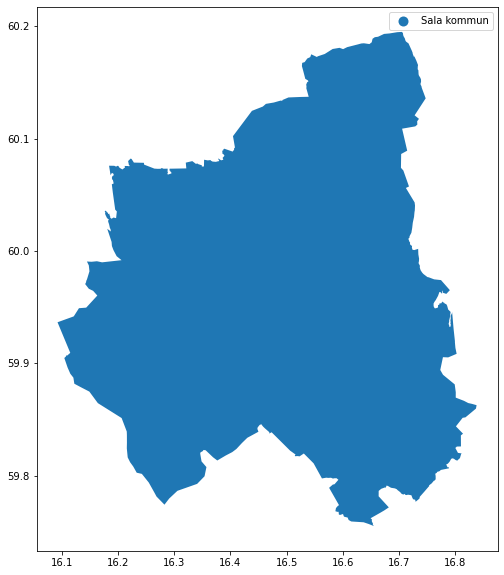

In [3]:
shape_name = 'Sala kommun'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

## Authenticate Google Earth Engine

In [4]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AdQt8qg7dZa7gm6s6ilt1B6d0HkRetnUd5kzKfPbGOEXM4JldKSUV1f-BvY



Successfully saved authorization token.


In [6]:
product='COPERNICUS/S2'
min_date='2018-01-01'
max_date='2020-01-01'
range_min=0
range_max=2000
cloud_pct=10

# Get the shape geometry for Sala kommun
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region)

image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()\
        .clip(region)

ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
# Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
# Map.addLayer(ndwi, {'palette': ['red', 'yellow', 'green', 'cyan', 'blue']}, 'NDWI')
# Map.addLayerControl()
# Map

## Create NDWI mask

In [78]:
# Create NDWI mask
ndwiThreshold = ndwi.gte(0.0)
ndwiMask = ndwiThreshold.updateMask(ndwiThreshold)
semiNdwiImage = ndwiThreshold.neq(0.0)
semiNdwiMask = ndwiThreshold.eq(0.0)
new_image = semiNdwiMask.multiply(0.5).add(semiNdwiImage.multiply(semiNdwiMask.neq(0.0)))
new_image = new_image.add(semiNdwiImage)

# var mask = image.gt(2)
# var new_image = mask.multiply(value).add(image.multiply(mask.not()))


# semiNdwiMask = semiNdwiMask.multiply(0.5).add(semiNdwiMask.multiply(ndwiThreshold.eq(0.0)))
# semiNdwiMask = semiNdwiMask.multiply(0.5)
semiNdwiMask = semiNdwiMask.multiply(0.5).add(ndwiThreshold.multiply(ndwiThreshold.eq(0.0)))
# semiNdwiMask = ndwiMask.multiply(0.5).add(ndwiMask.multiply(ndwiMask.eq(0.0)))
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(ndwi, {'palette': ['red', 'yellow', 'green', 'cyan', 'blue']}, 'NDWI')
Map.addLayer(ndwiThreshold, {'palette':['black','white']}, 'NDWI Binary Mask')
Map.addLayer(ndwiMask, {'palette':['blue']}, 'NDWI Mask')
Map.addLayer(semiNdwiImage, {'palette':['black','white']}, 'Semi NDWI Image')
Map.addLayer(semiNdwiMask, {'palette':['black','white']}, 'Semi NDWI Mask')
Map.addLayer(new_image, {'palette':['black','white']}, 'New Image')
Map.addLayerControl()
Map

## Export image to local GDrive

In [8]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.
    
    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of 
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))
        
    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()
    
    return task

In [15]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(image, shape_name + '_all_bands', region, folder)

Exporting to Sala kommun_all_bands.tif ...


In [19]:
task.status()

{'state': 'COMPLETED',
 'description': 'Sala kommun_all_bands',
 'creation_timestamp_ms': 1659363620976,
 'update_timestamp_ms': 1659364180349,
 'start_timestamp_ms': 1659363631660,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1jX4-3iUNKUNV5BkQOlJ37yLJ4tIkg09j'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 23348.125,
 'id': 'B7VZDU4OXH5MJGW7R2X6LRCB',
 'name': 'projects/earthengine-legacy/operations/B7VZDU4OXH5MJGW7R2X6LRCB'}

In [20]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
ndwiThresholdTask = export_image(ndwiThreshold, shape_name + '_ndwi_threshold', region, folder)

Exporting to Sala kommun_ndwi_threshold.tif ...


In [21]:
ndwiThresholdTask.status()

{'state': 'READY',
 'description': 'Sala kommun_ndwi_threshold',
 'creation_timestamp_ms': 1659364333599,
 'update_timestamp_ms': 1659364333599,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'QKYZZR6UVOYP4BRGR6UY7K4C',
 'name': 'projects/earthengine-legacy/operations/QKYZZR6UVOYP4BRGR6UY7K4C'}

In [22]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
ndwiMaskTask = export_image(ndwiMask, shape_name + '_ndwi_mask', region, folder)

Exporting to Sala kommun_ndwi_mask.tif ...


In [23]:
ndwiThresholdTask.status()

{'state': 'READY',
 'description': 'Sala kommun_ndwi_threshold',
 'creation_timestamp_ms': 1659364333599,
 'update_timestamp_ms': 1659364333599,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'QKYZZR6UVOYP4BRGR6UY7K4C',
 'name': 'projects/earthengine-legacy/operations/QKYZZR6UVOYP4BRGR6UY7K4C'}

In [79]:
newImageTask = export_image(new_image, shape_name + '_new_image', region, folder)

Exporting to Sala kommun_new_image.tif ...


In [85]:
newImageTask.status()

{'state': 'COMPLETED',
 'description': 'Sala kommun_new_image',
 'creation_timestamp_ms': 1659371462666,
 'update_timestamp_ms': 1659372258185,
 'start_timestamp_ms': 1659371467947,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1jX4-3iUNKUNV5BkQOlJ37yLJ4tIkg09j'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 3888.67138671875,
 'id': 'URTRBISTPAOIIKURSOUQZIE2',
 'name': 'projects/earthengine-legacy/operations/URTRBISTPAOIIKURSOUQZIE2'}

## Visualize Sentinel-2A Image

<class 'rasterio.io.DatasetReader'>


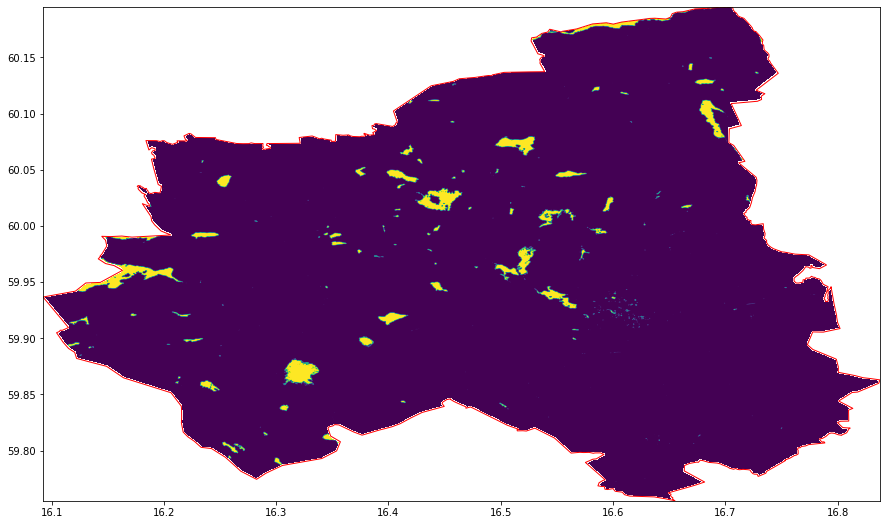

In [87]:
# Change this to your image file path
# tif_file = './drive/My Drive/Colab Notebooks/{}.tif'.format(shape_name) 
# tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}.tif'.format(shape_name) 
# tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}_ndwi_threshold.tif'.format(shape_name) 
tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}_new_image.tif'.format(shape_name) 

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);
print(type(image))

## Generate 64x64 px GeoJSON Tiles

In [88]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.
    
    Args:
      image_file (str): Image file path (.tif) 
      output_file (str): Output file path (.geojson) 
      area_str (str): Name of the region
      size(int): Window size
    
    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles 
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : [], 'area' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
        for w in range(0, width, size):
            for h in range(0, height, size):
                # Create a Window of your desired size
                window = rio.windows.Window(h, w, size, size)
                # Get the georeferenced window bounds
                bbox = rio.windows.bounds(window, raster.transform)
                # Create a shapely geometry from the bounding box
                bbox = box(*bbox)

                # Create a unique id for each geometry
                uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

                # Update dictionary
                geo_dict['id'].append(uid)
                geo_dict['area'].append(area_str)
                geo_dict['geometry'].append(bbox)

                index += 1
                pbar.update(size*size)
    
    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of size 64x64 px across the Sala kommun Sentinel-2 satellite image.

In [89]:
# cwd = './drive/My Drive/Colab Notebooks/Land Use and Land Cover Classification/'
cwd = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/Land Use and Land Cover Classification'
output_file = cwd+'{}.geojson'.format(shape_name)
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/40630409 [00:00<?, ?it/s]

/Users/frape/miniforge3/envs/deep_wetlands/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (10010, 3)


,id,geometry,area
0,sala_kommun-0,"POLYGON ((16.09808 60.18937, 16.09808 60.19512...",Sala kommun
1,sala_kommun-1,"POLYGON ((16.10383 60.18937, 16.10383 60.19512...",Sala kommun
2,sala_kommun-2,"POLYGON ((16.10958 60.18937, 16.10958 60.19512...",Sala kommun


## Visualize 64x64 px Tiles

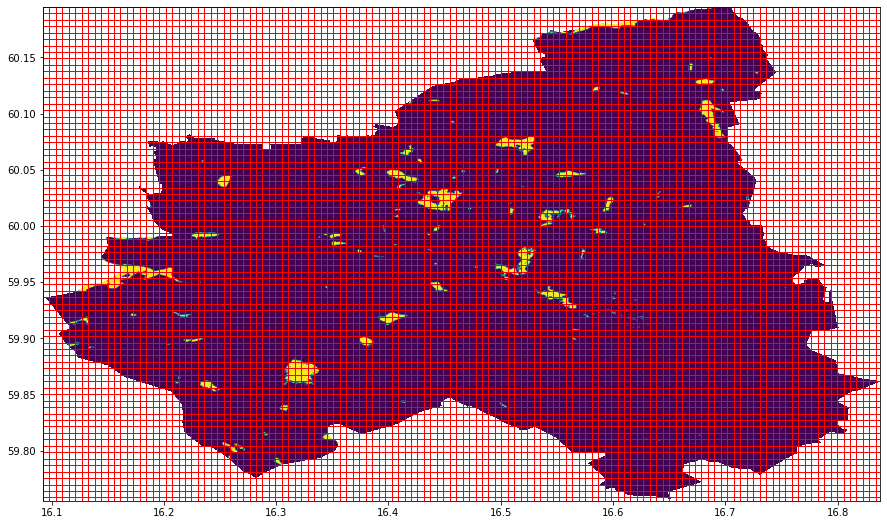

In [90]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Notice that the polygons are generated for empty (black) regions as well. Using our model to predict on blank regions seems computationally wasteful.

Instead, we can get the intersection between: 
- the Kreis Borken boundary polygon and 
- the 64 x 64 grid tiles.

To do this, we use GeoPandas `.sjoin()` function. We set parameter `op='within'` to indicate that we only want the tiles that lie within the district boundary.

[See  more information on GeoPandas sjoin operation here](https://geopandas.org/reference/geopandas.sjoin.html).


/Users/frape/miniforge3/envs/deep_wetlands/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/bk/sld6vd3d79dghhg7k3cxn1v80000gp/T/ipykernel_36563/2778194479.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


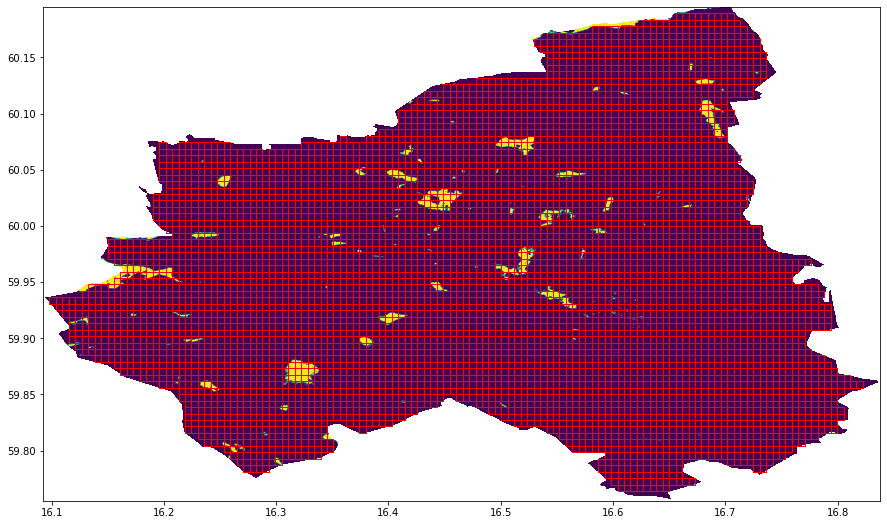

In [91]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualize Single Cropped Image

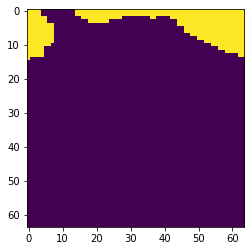

(1, 64, 64) <class 'numpy.ndarray'>
[[[1.  1.  1.  ... 1.  1.  1. ]
  [1.  1.  1.  ... 1.  1.  1. ]
  [1.  1.  1.  ... 1.  1.  1. ]
  ...
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]]


In [121]:
def show_crop(image, shape, title=''):
    """Crops an image based on the polygon shape.
    Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

    Args:
        image (str): Image file path (.tif) 
        shape (geometry): The tile with which to crop the image
        title(str): Image title
    """
  
    with rio.open(image) as src:
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        # _, x_nonzero, y_nonzero = np.nonzero(out_image)
        # out_image = out_image[
        #     :,
        #     np.min(x_nonzero):np.max(x_nonzero), 
        #     np.min(y_nonzero):np.max(y_nonzero)
        # ]
        if out_image.shape[1] == 65:
            out_image = out_image[:,:-1,:]
        if out_image.shape[2] == 65:
            out_image = out_image[:,:,1:]
        
        # Min-max scale the data to range [0, 1]
        # out_image[out_image > maxValue] = maxValue
        # out_image[out_image < minValue] = minValue
        # out_image = (out_image - minValue)/(maxValue - minValue)
        
        # Visualize image
        show(out_image, title=title)
        print(out_image.shape, type(out_image))
        print(out_image)

show_crop(tif_file, [tiles.iloc[10]['geometry']])

In [100]:
print(type(tiles), tiles.size)

<class 'geopandas.geodataframe.GeoDataFrame'> 50454


In [122]:
minValue = 0.5
maxValue = 1.0

def export_ndwi_mask_data():
    for index in tqdm(range(len(tiles)), total=len(tiles)):

        with rio.open(tif_file) as src:

            shape = [tiles.iloc[index]['geometry']]
            name = tiles.iloc[index]['id']
            # print('id', name)
            # print(type(src), type(shape))
            out_image, out_transform = rio.mask.mask(src, shape, crop=True)
            # Crop out black (zero) border
            # _, x_nonzero, y_nonzero = np.nonzero(out_image)
            # out_image = out_image[
            #     :,
            #     np.min(x_nonzero):np.max(x_nonzero), 
            #     np.min(y_nonzero):np.max(y_nonzero)
            # ]
            if out_image.shape[1] == 65:
                out_image = out_image[:,:-1,:]
            if out_image.shape[2] == 65:
                out_image = out_image[:,:,1:]

            # Min-max scale the data to range [0, 1]
            out_image[out_image > maxValue] = maxValue
            out_image[out_image < minValue] = minValue
            out_image = (out_image - minValue)/(maxValue - minValue)

            # Get the metadata of the source image and update it
            # with the width, height, and transform of the cropped image
            out_meta = src.meta
            out_meta.update({
                  "driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform
            })

            # Save the cropped image as a temporary TIFF file.
            temp_tif = '/tmp/ndwi_mask/{}-ndwi_mask.tif'.format(name)
            with rasterio.open(temp_tif, "w", **out_meta) as dest:
                dest.write(out_image) 

In [123]:
export_ndwi_mask_data()

  0%|          | 0/5606 [00:00<?, ?it/s]

1
(64, 64)


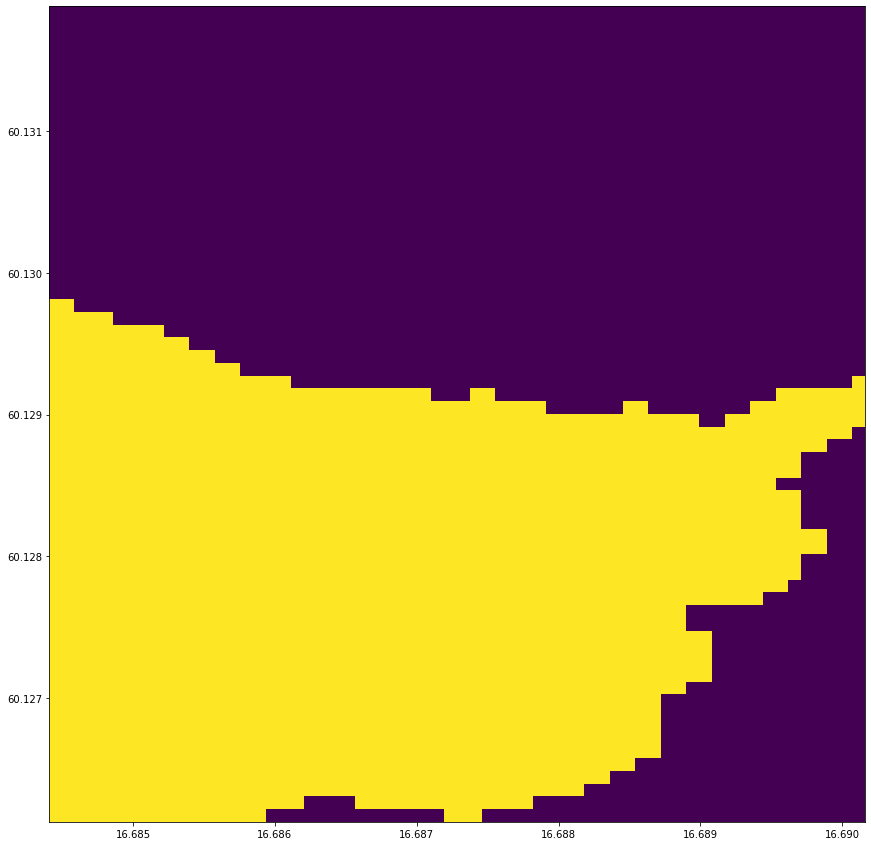

In [124]:
# Open image file using Rasterio
image = rio.open('/tmp/ndwi_mask/sala_kommun-1533-ndwi_mask.tif')

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
show(image, ax=ax);
print(image.count)
print(image.read(1).shape)